In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#simple bimodal
#first, train on noisy discrimination task
#x = a + \epsilon
#a = 1 or 2
#noise in network = 0

In [4]:
#generate training set
train_set_1 = torch.rand(1,1000)*10 + 2
train_set_2 = -torch.rand(1,1000)*10 - 2

In [5]:
class network1():
    def simulation(w,train_set,tau_m = 0.02,dt = 0.001):
        #1000 steps
        #input tensor
        r = torch.randn((4,1000)).float()
        for j in range(1500):
            r = r+dt/tau_m*(-r + m(w@r + 10*train_set))
        return r
    
    '''update loss for parallel simulation'''
    def loss_1(r, a = 10):
        return a*torch.sum((r[2] - 1)**2)
    
    def loss_2(r, b = 10):
        return b*torch.sum((r[2] + 1)**2)

In [6]:
max_eig = True
while max_eig:
    w = torch.autograd.Variable(torch.randn(4,4),requires_grad = True).float()
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False
        
m = torch.nn.Tanh()

optimizer = torch.optim.Adam([w], 0.2)

In [7]:
optimizer = torch.optim.Adam([w], 0.05)
#train on set 01 first
import sys
loss_list = []
L = 0
for v in range(20):
    optimizer.zero_grad()
    resp_1 = network1.simulation(w,train_set_1,tau_m = 0.02,dt = 0.001)
    L = network1.loss_1(resp_1)
    
    resp_2 = network1.simulation(w,train_set_2,tau_m = 0.02,dt = 0.001)
    L = L + network1.loss_2(resp_2)
    L1 = L.detach().numpy().copy()
    #print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()

In [8]:
loss_list[-1]

array(1.0835777e-08, dtype=float32)

In [9]:
resp_all_1 = network1.simulation(w,train_set_1,tau_m = 0.02,dt = 0.001).detach().numpy()
resp_all_2 = network1.simulation(w,train_set_2,tau_m = 0.02,dt = 0.001).detach().numpy()
resp_all = np.hstack((resp_all_1,resp_all_2))
resp_all.shape

(4, 2000)

In [10]:
def simulation(w,test_input,tau_m = 0.02,dt = 0.001):
        #1000 steps
        #input tensor
        r = torch.randn((4,1)).float()
        resp = torch.zeros(4,1500).float()
        for j in range(1500):
            r = r+dt/tau_m*(-r + m(w@r + 10*test_input))
            resp[:,j] = torch.reshape(r,(1,4))
        return resp, r

In [11]:
resp1, r = simulation(w,torch.tensor([-0.1]))
resp1 = resp1.detach().numpy()
r = r.detach().numpy()

resp2, r = simulation(w,torch.tensor([0.3]))
resp2 = resp2.detach().numpy()
r = r.detach().numpy()

Text(0.5, 0, 't')

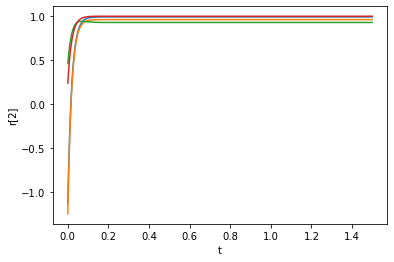

In [12]:
#plt.plot(0.001*np.arange(0,1500), resp1.T)
plt.plot(0.001*np.arange(0,1500), resp2.T)
#plt.legend(['h=-0.5','0.5'])
plt.ylabel('r[2]')
plt.xlabel('t')

In [13]:
print(w)

tensor([[ 0.0029,  0.3361, -0.0046, -0.6500],
        [-0.2052, -0.1303, -0.0060, -0.7214],
        [-0.7778, -0.7675,  0.0414,  0.1076],
        [-0.0270, -0.1252,  0.2329,  0.3993]], requires_grad=True)


In [14]:
def simulation1(w,test_input,tau_m = 0.02,dt = 0.001,sigma = 0.01):
        #1000 steps
        #input tensor
        r = torch.randn((4,1)).float()
        resp = torch.zeros(4,200000).float()
        for j in range(200000):
            r = r+dt/tau_m*(-r + m(w@r + 10*test_input)) + sigma*(2/tau_m)**0.5*dt**0.5*torch.randn(4,1)
            resp[:,j] = torch.reshape(r,(1,4))
        return resp, r

In [34]:
resp_n, r_n = simulation1(w,torch.tensor([0]), sigma = 1)
resp_n = resp_n.detach().numpy()
r_n = r_n.detach().numpy()

Text(0.5, 0, 't')

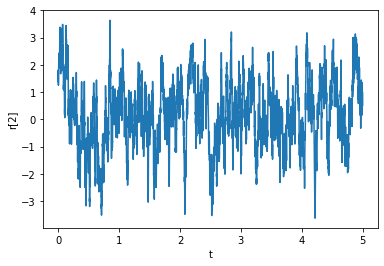

In [35]:
plt.plot(0.001*np.arange(5000),resp_n[2,10000:15000].T)
plt.ylabel('r[2]')
plt.xlabel('t')

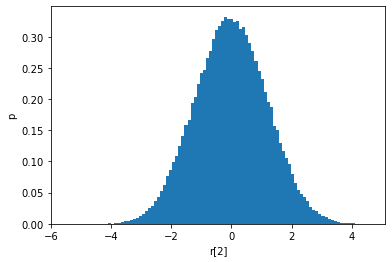

In [36]:
plt.hist(resp_n[2,:].T,bins = 100, density = 'True')
plt.xlabel('r[2]')
plt.ylabel('p')
plt.show()

In [37]:
#PCA

In [38]:
def simulation_all(w,train_set,tau_m = 0.02,dt = 0.001):
        #1000 steps
        #input tensor
        r = torch.randn((4,1000)).float()
        resp_0 = torch.zeros(1000,300).float()
        resp_1 = torch.zeros(1000,300).float()
        resp_2 = torch.zeros(1000,300).float()
        resp_3 = torch.zeros(1000,300).float()
        for j in range(300):
            r = r+dt/tau_m*(-r + m(w.detach()@r + 10*train_set))
            resp_0[:,j] = r[0,:]
            resp_1[:,j] = r[1,:]
            resp_2[:,j] = r[2,:]
            resp_3[:,j] = r[3,:]
        return np.array([resp_0.numpy().reshape(-1),resp_1.numpy().reshape(-1),resp_2.numpy().reshape(-1),resp_3.numpy().reshape(-1)])

In [39]:
resp_all_1 = np.hstack((simulation_all(w,train_set_1,tau_m = 0.02,dt = 0.001),simulation_all(w,train_set_1,tau_m = 0.02,dt = 0.001)))

In [40]:
np.linalg.eig(resp_all_1@resp_all_1.T)

(array([2189059.8  ,   19219.434,   19772.588,   18041.242], dtype=float32),
 array([[-0.4994961 ,  0.8494081 , -0.1680636 ,  0.02764399],
        [-0.5006321 , -0.3722889 , -0.49336392, -0.60610276],
        [-0.49984616, -0.12234645,  0.83561665, -0.19217178],
        [-0.500025  , -0.35346603, -0.17346902,  0.77132696]],
       dtype=float32))

In [41]:
def simulation_all1(w,train_set,tau_m = 0.02,dt = 0.001):
        #1000 steps
        #input tensor
        r = torch.randn((4,1000)).float()
        resp_0 = torch.zeros(1000,500).float()
        resp_1 = torch.zeros(1000,500).float()
        resp_2 = torch.zeros(1000,500).float()
        resp_3 = torch.zeros(1000,500).float()
        for j in range(500):
            r = r+dt/tau_m*(-r + m(w.detach()@r + 10*train_set))
            resp_0[:,j] = r[0,:]
            resp_1[:,j] = r[1,:]
            resp_2[:,j] = r[2,:]
            resp_3[:,j] = r[3,:]
        return resp_0 + resp_1 + resp_2 + resp_3, resp_0 - resp_1 + resp_2 - resp_3

In [42]:
a1,b1 = simulation_all1(w,train_set_1,tau_m = 0.02,dt = 0.001)
a2,b2 = simulation_all1(w,train_set_2,tau_m = 0.02,dt = 0.001)
resp_all_1 = np.vstack((a1,a2))
resp_all_2 = np.vstack((b1,b2))

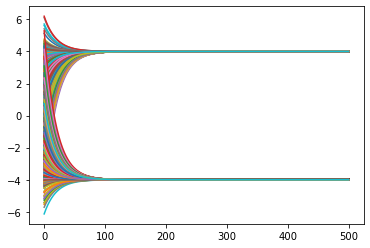

In [43]:
plt.plot(resp_all_1.T)
plt.show()

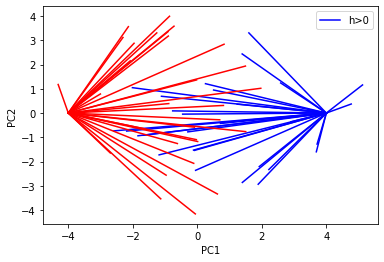

In [44]:
plt.plot(resp_all_1.T[:,:30], resp_all_2.T[:,:30], c = 'b')
plt.plot(resp_all_1.T[:,1000:1030], resp_all_2.T[:,1000:1030], c = 'r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['h>0'])
plt.show()

In [45]:
#next step: study fix points in the RNN
#|f(wr + h) - r|^2


In [46]:
#train noise covariance to control the shape of bimodal distribution

In [50]:
w_trained = w.detach().numpy()

In [55]:
energy = np.zeros(1000)
r_trial = np.ones((4,1))
h = 1
x_i = np.linspace(2,6,1000)
i = 0
for j in x_i:
    c = j/4*r_trial
    energy[i] = np.sum((np.tanh(w_trained@c + 10*h) - c)**2)
    i = i+1

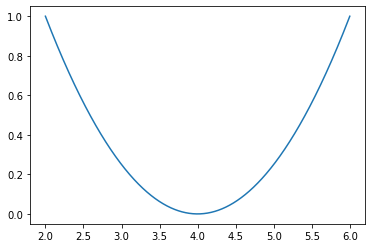

In [56]:
plt.plot(x_i,energy)